In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

keras = tf.keras

In [2]:
df_companies = pd.read_csv('companies.csv', error_bad_lines=False, header=None)
df_companies.columns = ['names']
df_companies

b'Skipping line 31: expected 1 fields, saw 2\nSkipping line 74: expected 1 fields, saw 2\n'


,names
0,Hashplay Inc.
1,New Incentives
2,GrabJobs
3,MediBookr
4,MelissaWithLove.co
...,...
172479,ZyroFisher
172480,Zytex group
172481,Zytoservice
172482,Zywave


In [3]:
corpus = '\n'.join(df_companies['names'].tolist())
corpus_length = len(corpus)
print("Loaded a corpus of {0} characters".format(corpus_length))

Loaded a corpus of 2560310 characters


In [4]:
# Get a unique identifier for each char in the corpus, 
# then make some dicts to ease encoding and decoding
chars = sorted(list(set(corpus)))
num_chars = len(chars)
encoding = {c: i for i, c in enumerate(chars)}
decoding = {i: c for i, c in enumerate(chars)}
print("Our corpus contains {0} unique characters.".format(num_chars))

Our corpus contains 150 unique characters.


In [5]:
print(encoding)
print(decoding)

{'\n': 0, ' ': 1, '!': 2, '"': 3, '#': 4, '$': 5, '%': 6, '&': 7, "'": 8, '(': 9, ')': 10, '*': 11, '+': 12, ',': 13, '-': 14, '.': 15, '/': 16, '0': 17, '1': 18, '2': 19, '3': 20, '4': 21, '5': 22, '6': 23, '7': 24, '8': 25, '9': 26, ':': 27, '=': 28, '>': 29, '?': 30, '@': 31, 'A': 32, 'B': 33, 'C': 34, 'D': 35, 'E': 36, 'F': 37, 'G': 38, 'H': 39, 'I': 40, 'J': 41, 'K': 42, 'L': 43, 'M': 44, 'N': 45, 'O': 46, 'P': 47, 'Q': 48, 'R': 49, 'S': 50, 'T': 51, 'U': 52, 'V': 53, 'W': 54, 'X': 55, 'Y': 56, 'Z': 57, '[': 58, '\\': 59, ']': 60, '^': 61, '_': 62, 'a': 63, 'b': 64, 'c': 65, 'd': 66, 'e': 67, 'f': 68, 'g': 69, 'h': 70, 'i': 71, 'j': 72, 'k': 73, 'l': 74, 'm': 75, 'n': 76, 'o': 77, 'p': 78, 'q': 79, 'r': 80, 's': 81, 't': 82, 'u': 83, 'v': 84, 'w': 85, 'x': 86, 'y': 87, 'z': 88, '{': 89, '|': 90, '}': 91, '~': 92, '\x81': 93, '\x82': 94, '\x83': 95, '\x84': 96, '\x85': 97, '\x86': 98, '\x87': 99, '\x88': 100, '\x89': 101, '\x8a': 102, '\x8b': 103, '\x8c': 104, '\x8d': 105, '\x8e': 

## One to many approach

In [6]:
# chop up our data into X and y, slice into roughly 
# (num_chars / skip) overlapping 'sentences' of length 
# sentence_length, and encode the chars
sentence_length = 10
skip = 3
X_data = []
y_data = []
for i in range (0, len(corpus) - sentence_length, skip):
    sentence = corpus[i:i + sentence_length]
    next_char = corpus[i + sentence_length]
    X_data.append([encoding[char] for char in sentence])
    y_data.append(encoding[next_char])

num_sentences = len(X_data)
print("Sliced our corpus into {0} sentences of length {1}"
      .format(num_sentences, sentence_length))

Sliced our corpus into 853434 sentences of length 10


In [7]:
print(X_data[0])
print([decoding[idx] for idx in X_data[0]])
print(decoding[y_data[0]])

[39, 63, 81, 70, 78, 74, 63, 87, 1, 40]
['H', 'a', 's', 'h', 'p', 'l', 'a', 'y', ' ', 'I']
n


In [8]:
# Vectorize our data and labels. We want everything in one-hot.
X = np.zeros((num_sentences, sentence_length, num_chars), dtype=np.bool)
y = np.zeros((num_sentences, num_chars), dtype=np.bool)
for i, sentence in enumerate(X_data):
    for t, encoded_char in enumerate(sentence):
        X[i, t, encoded_char] = 1
    y[i, y_data[i]] = 1

# Double check our vectorized data before we sink hours into fitting a model
print("Sanity check y. Dimension: {0} # Sentences: {1} Characters in corpus: {2}"
      .format(y.shape, num_sentences, len(chars)))
print("Sanity check X. Dimension: {0} Sentence length: {1}"
      .format(X.shape, sentence_length))

Sanity check y. Dimension: (853434, 150) # Sentences: 853434 Characters in corpus: 150
Sanity check X. Dimension: (853434, 10, 150) Sentence length: 10


In [9]:
# Define our model
model = keras.models.Sequential()
model.add(keras.layers.SimpleRNN(64, input_shape=(sentence_length, num_chars), 
                    return_sequences=False))
model.add(keras.layers.Dense(num_chars))
model.add(keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', 
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 64)                13760     
_________________________________________________________________
dense (Dense)                (None, 150)               9750      
_________________________________________________________________
activation (Activation)      (None, 150)               0         
Total params: 23,510
Trainable params: 23,510
Non-trainable params: 0
_________________________________________________________________


Epoch 1/10
6668/6668 [==============================] - 34s 5ms/step - loss: 2.6064 - accuracy: 0.2772
Epoch 2/10
6668/6668 [==============================] - 33s 5ms/step - loss: 2.3089 - accuracy: 0.3472
Epoch 3/10
6668/6668 [==============================] - 26s 4ms/step - loss: 2.2359 - accuracy: 0.3657
Epoch 4/10
6668/6668 [==============================] - 23s 3ms/step - loss: 2.1959 - accuracy: 0.3763
Epoch 5/10
6668/6668 [==============================] - 23s 3ms/step - loss: 2.1700 - accuracy: 0.3832
Epoch 6/10
6668/6668 [==============================] - 23s 3ms/step - loss: 2.1518 - accuracy: 0.3881
Epoch 7/10
6668/6668 [==============================] - 23s 4ms/step - loss: 2.1381 - accuracy: 0.3915
Epoch 8/10
6668/6668 [==============================] - 24s 4ms/step - loss: 2.1277 - accuracy: 0.3951
Epoch 9/10
6668/6668 [==============================] - 24s 4ms/step - loss: 2.1193 - accuracy: 0.3975
Epoch 10/10
6668/6668 [==============================] - 24s 4ms/step - l

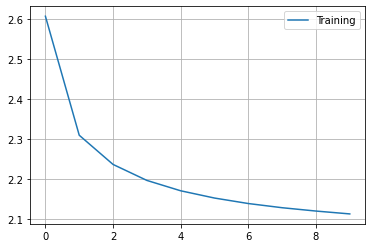

In [10]:
#training time
log = model.fit(X, y, epochs=10, batch_size=128)
plt.plot(log.history['loss'], label='Training')
plt.legend()
plt.grid()

In [15]:
def make_seed(seed_phrase=""):
    if seed_phrase:  # make sure the seed has the right length
        phrase_length = len(seed_phrase)
        pattern = ""
        for i in range (0, sentence_length):
            pattern += seed_phrase[i % phrase_length]
    else:            # sample randomly the seed from corpus
        seed = random.randint(0, corpus_length - sentence_length)
        pattern = corpus[seed:seed + sentence_length]
        
    return pattern

seed_pattern = make_seed("Software ")
print("seed = " + seed_pattern)

X = np.zeros((1, sentence_length, num_chars), dtype=np.float)
for i, character in enumerate(seed_pattern):
    X[0, i, encoding[character]] = 1

print()
generated_text = seed_pattern
for i in range(100):
    output_prob = model.predict(X, verbose=0)[0]
    # in previous line predict() gives a tensor of shape (1, 65) 
    # with 1 being the size of the batch, for that we use [0] to get a vector
    prediction = np.random.choice(num_chars, p = output_prob )
    generated_text += decoding[prediction]
    activations = np.zeros((1, 1, num_chars), dtype=np.bool)
    activations[0, 0, prediction] = 1
    #now remove first char and glue the predicted one
    X = np.concatenate((X[:, 1:, :], activations), axis=1)
print(generated_text)

seed = Software S

Software Susters
36 Group
Uniopain Ptr
Imtridal
Kiejial Aciomerve
Phermain
PluckARTV Packet
Lign Technology He
